In [6]:
import argparse
import numpy as np
import pandas as pd
import sys
import datetime as dt
from dateutil.parser import parse

In [7]:
from abides_core.kernel import Kernel
from abides_markets.agents.exchange_agent import ExchangeAgent
from abides_markets.agents.market_makers.adaptive_market_maker_agent import AdaptiveMarketMakerAgent


In [8]:
from abides_markets.configs import rmsc04
from abides_core import abides

In [9]:
from abides_core.kernel import Kernel as Simulator
from abides_markets.agents.exchange_agent import ExchangeAgent as Agent

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

class DynamicPDE_LSMC:
    """
    Solve the dynamic programming PDE system for Phi0, Phi1, Phi2 via LSMC.
    
    PDEs:
      ∂t Φ0 + ½σ² Φ0_ss - γ(Φ0_s)²
         + (Λ/γ)[1 - k Δ0 + (Δ0)²]
         + (A/(κ+γ))[2 - k (2Φ2 + (2/γ)ln(1+γ/k))] = 0
      ∂t Φ1 + ½σ² Φ1_ss - 2γ Φ0_s Φ1_s
         + (Λ/γ)[-k Δ1 + 2Δ0 Δ1]
         + ½(σ²-σ_imp²)S² O_ss + [O(s e^z)-O(s)] = 0
      ∂t Φ2 + ¼σ² Φ2_ss - γ[(Φ1_s)² + Φ0_s Φ2_s]
         + (Λ/γ)[-½k Δ2 + (Δ1)² + Δ0 Δ2] = 0

    Terminal conditions at t=T:
      Φ0(T,s) = 0
      Φ1(T,s) = -a
      Φ2(T,s) = -2a
    """
    """
    S0 : float : initial stock/index level
    T : float : time to maturity (in year fractions)
    M : int : grid or granularity for time (in number of total points)
    r : float : constant risk-free short rate
    sigma :  float : volatility factor in diffusion term 
    simulations: int: need to be even number
    """
    def __init__(self, S0, sigma,gamma, sigma_imp, lam, Lambda, kappa, A, z, a,
                 strike, T, M, is_call=True, r=0.0, sims=10000, basis_deg=1, seed=42):
        self.S0         = S0
        self.sigma      = sigma        # underlying volatility
        self.sigma_imp  = sigma_imp    # implied vol for option
        self.lam        = lam          #Poisson Parameter
        self.Lambda     = Lambda       #Jump Intensity Function
        self.gamma      = gamma        #Risk aversion parameter
        self.kappa      = kappa        #Decay Parameter of Order Intensity
        self.A          = A            #Order Intensity Function
        self.z          = z            #Stock jump magnitude
        self.jump_mult  = np.exp(z)    #Stock jump 
        self.a          = a            #Terminal Condition Parameter
        self.strike     = strike       #Stock strike price
        self.T          = T            #time to maturity (in year fractions)
        self.M          = M            #grid or granularity for time (in number of total points)
        self.dt         = T / M        #time step    
        self.r          = r            #interest rate
        self.is_call    = is_call      #True for Call, False for Put 
        self.sims       = sims         #Numer of simulations
        self.basis_deg  = basis_deg    #Degree of Polynomial for Least squares Monte Carlo 
        self.phi0_t     = None
        self.phi0_s     = None
        self.phi0_ss    = None
        self.phi0_jump  = None
        np.random.seed(seed)
        

        # simulate underlying paths
        self.S_paths = self._sim_paths()

        # allocate phi arrays
        self.phi0 = np.zeros_like(self.S_paths)
        self.phi1 = np.zeros_like(self.S_paths)
        self.phi2 = np.zeros_like(self.S_paths)
        # terminal conditions
        self.phi0[:, -1] = 0.0
        self.phi1[:, -1] = -self.a
        self.phi2[:, -1] = -2 * self.a

    def _sim_paths(self):
        S = np.zeros((self.sims, self.M+1))
        S[:,0] = self.S0
        for t in range(1, self.M+1):
            half = np.random.standard_normal(self.sims//2)
            dW   = np.concatenate((half, -half)) * np.sqrt(self.dt)
            Nj   = np.random.poisson(self.lam * self.dt, size=self.sims)
            jump_factor = np.exp(self.z * Nj)
            mu  = self.r - 0.5*self.sigma**2 - self.lam*(np.exp(self.z)-1)
            dX  = mu*self.dt + self.sigma * dW
            S[:,t] = S[:,t-1] * np.exp(dX) * jump_factor
        return S
    
    @staticmethod
    def BS_d1(S, K, r, sigma, tau):
        return (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    @staticmethod
    def BSCall(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        d2 = d1 - sigma * np.sqrt(tau)
        return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

    @staticmethod
    def BSPut(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        d2 = d1 - sigma * np.sqrt(tau)
        return K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)

    @staticmethod
    def vega(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        return S * norm.pdf(d1) * np.sqrt(tau)

    @staticmethod
    def gamma_O(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        return norm.pdf(d1) / (S * sigma * np.sqrt(tau))

    @staticmethod
    def find_ivol(target_value, S, K, r, tau,
                  MAX_ITERATIONS=200, PRECISION=1e-8, sigma0=0.5):
        """
        Newton–Raphson to solve BSCall(S,K,r,σ,τ) = target_value for σ.
        """
        sigma = sigma0
        for i in range(MAX_ITERATIONS):
            price = DynamicPDE_LSMC.BSCall(S, K, r, sigma, tau)
            vega_ = DynamicPDE_LSMC.vega(S, K, r, sigma, tau)
            diff = target_value - price
            if abs(diff) < PRECISION:
                return sigma
            sigma += diff / vega_
        print("Warning: max iterations reached in implied-vol computation")
        return sigma

    def _driver_phi0(self, S_next, phi0_next, phi2_next):
        Δ0 = np.interp(S_next*np.exp(self.z), S_next, phi0_next) - phi0_next
        jump = (self.Lambda/self.gamma)*(1 - self.kappa*Δ0 + Δ0**2)
        spread = 2*phi2_next + (2/self.gamma)*np.log(1 + self.gamma/self.kappa)
        quote  = (self.A/(self.kappa + self.gamma)) * (2 - self.kappa*spread)
        return jump + quote

    def _driver_phi1(self, t_next, S_next, phi0_next, phi1_next):
        # jump part
        Δ1 = np.interp(S_next*self.jump_mult, S_next, phi1_next) - phi1_next
        Δ0 = np.interp(S_next*self.jump_mult, S_next, phi0_next) - phi0_next
        jump = (self.Lambda/self.gamma)*(-self.kappa*Δ1 + 2*Δ0*Δ1)

        # Black-Scholes option price & gamma for continuation
        tau = max(self.T - t_next, 1e-8)
        if self.is_call:
            O   = DynamicPDE_LSMC.BSCall(S_next, self.strike, self.r, self.sigma_imp, tau)
            O_j = DynamicPDE_LSMC.BSCall(S_next*self.jump_mult, self.strike, self.r, self.sigma_imp, tau)
            gamma_O = DynamicPDE_LSMC.gamma_O(S_next, self.strike, self.r, self.sigma, tau)
            
        else:
            O   = DynamicPDE_LSMC.BSPut(S_next, self.strike, self.r, self.sigma_imp, tau)
            O_j = DynamicPDE_LSMC.BSPut(S_next*self.jump_mult, self.strike, self.r, self.sigma_imp, tau)
            gamma_O = DynamicPDE_LSMC.gamma_O(S_next, self.strike, self.r, self.sigma, tau)

        cont = 0.5*(self.sigma**2 - self.sigma_imp**2)*S_next**2 * gamma_O
        cont += (O_j - O)
        return jump + cont

    def _driver_phi2(self, S_next, phi1_next, phi0_next, phi2_next):
        Δ2 = np.interp(S_next*self.jump_mult, S_next, phi2_next) - phi2_next
        Δ1 = np.interp(S_next*self.jump_mult, S_next, phi1_next) - phi1_next
        Δ0 = np.interp(S_next*self.jump_mult, S_next, phi0_next) - phi0_next
        jump = (self.Lambda/self.gamma)*(-0.5*self.kappa*Δ2 + Δ1**2 + Δ0*Δ2)
        return jump

    def solve(self):
        times = np.linspace(0, self.T, self.M + 1)
        # pre-allocate outputs
        self.delta_sum     = np.zeros((self.sims, self.M))
        self.phi0_t        = np.zeros((self.sims, self.M))
        self.Phi0_s        = np.zeros((self.sims, self.M))
        self.Phi0_ss       = np.zeros((self.sims, self.M))
        self.Phi0_jump     = np.zeros((self.sims, self.M))
        self.phi1_t        = np.zeros((self.sims, self.M))
        self.Phi1_s        = np.zeros((self.sims, self.M))
        self.Phi1_ss       = np.zeros((self.sims, self.M))
        self.Phi1_jump     = np.zeros((self.sims, self.M))
        self.phi2_t        = np.zeros((self.sims, self.M))
        self.Phi2_s        = np.zeros((self.sims, self.M))
        self.Phi2_ss       = np.zeros((self.sims, self.M))
        self.Phi2_jump     = np.zeros((self.sims, self.M))
        
        for n in reversed(range(self.M)):
            t_next  = times[n+1]
            S_n     = self.S_paths[:, n]
            S_np1   = self.S_paths[:, n+1]
            p0n1    = self.phi0[:, n+1]
            p1n1    = self.phi1[:, n+1]
            p2n1    = self.phi2[:, n+1]

            # 1) Fit φ0 -----------------------------------------------------
            Y0    = p0n1 + self._driver_phi0(S_np1, p0n1, p2n1) * self.dt
            X_n   = np.vander(S_n, N=self.basis_deg+1, increasing=True)
            lr0   = LinearRegression().fit(X_n, Y0)
            self.phi0[:,n] = lr0.predict(X_n)
            coef0 = lr0.coef_

            # eval φ0 at S_np1 and jump spots
            X_np1   = np.vander(S_np1,N=self.basis_deg+1, increasing=True)
            phi0_np1= lr0.predict(X_np1)
            X_j0    = np.vander(S_np1*np.exp(self.z), N=self.basis_deg+1, increasing=True)
            phi0_jmp= lr0.predict(X_j0)
            Delta0  = phi0_jmp - phi0_np1
            self.Phi0_jump[:,n] = Delta0

            # derivatives φ0
            self.phi0_t[:,n] = (self.phi0[:,n] - p0n1) / self.dt
            ds0, dss0 = np.zeros_like(S_np1), np.zeros_like(S_np1)
            for j in range(1, self.basis_deg+1):
                ds0  += j*coef0[j]  * S_np1**(j-1)
            for j in range(2, self.basis_deg+1):
                dss0 += j*(j-1)*coef0[j] * S_np1**(j-2)
            self.Phi0_s[:,n], self.Phi0_ss[:,n] = ds0, dss0

            # 2) Fit φ1 -----------------------------------------------------
            Y1    = p1n1 + self._driver_phi1(t_next, S_np1, p0n1, p1n1) * self.dt
            lr1   = LinearRegression().fit(X_n, Y1)
            self.phi1[:,n] = lr1.predict(X_n)
            coef1 = lr1.coef_

            # eval φ1 jump increment
            phi1_np1= lr1.predict(X_np1)
            X_j1    = np.vander(S_np1*np.exp(self.z), N=self.basis_deg+1, increasing=True)
            phi1_jmp= lr1.predict(X_j1)
            Delta1  = phi1_jmp - phi1_np1
            self.Phi1_jump[:,n] = Delta1

            # derivatives φ1
            self.phi1_t[:,n] = (self.phi1[:,n] - p1n1) / self.dt
            ds1, dss1 = np.zeros_like(S_np1), np.zeros_like(S_np1)
            for j in range(1, self.basis_deg+1):
                ds1  += j*coef1[j]  * S_np1**(j-1)
            for j in range(2, self.basis_deg+1):
                dss1 += j*(j-1)*coef1[j] * S_np1**(j-2)
            self.Phi1_s[:,n], self.Phi1_ss[:,n] = ds1, dss1

            # 3) Fit φ2 -----------------------------------------------------
            Y2    = p2n1 + self._driver_phi2(S_np1, p1n1, p0n1, p2n1) * self.dt
            lr2   = LinearRegression().fit(X_n, Y2)
            self.phi2[:,n] = lr2.predict(X_n)
            coef2 = lr2.coef_

            # eval φ2 jump increment
            phi2_np1= lr2.predict(X_np1)
            X_j2    = np.vander(S_np1*np.exp(self.z), N=self.basis_deg+1, increasing=True)
            phi2_jmp= lr2.predict(X_j2)
            Delta2  = phi2_jmp - phi2_np1
            self.Phi2_jump[:,n] = Delta2

            # derivatives φ2
            self.phi2_t[:,n] = (self.phi2[:,n] - p2n1) / self.dt
            ds2, dss2 = np.zeros_like(S_np1), np.zeros_like(S_np1)
            for j in range(1, self.basis_deg+1):
                ds2  += j*coef2[j]  * S_np1**(j-1)
            for j in range(2, self.basis_deg+1):
                dss2 += j*(j-1)*coef2[j] * S_np1**(j-2)
            self.Phi2_s[:,n], self.Phi2_ss[:,n] = ds2, dss2
        
        return (
            self.phi0, self.phi1, self.phi2,
            self.phi0_t, self.Phi0_s, self.Phi0_ss, self.Phi0_jump,
            self.phi1_t, self.Phi1_s, self.Phi1_ss, self.Phi1_jump,
            self.phi2_t, self.Phi2_s, self.Phi2_ss, self.Phi2_jump)
    def optimal_spread(self):
        # Averages at t=0 across all Monte Carlo paths
        phi0_t    = self.phi0_t[:,    0].mean()
        phi0_s    = self.Phi0_s[:,    0].mean()
        phi0_ss   = self.Phi0_ss[:,   0].mean()
        phi0_jump = self.Phi0_jump[:, 0].mean()
        # Numerator of δ_a + δ_b from the q=0 PDE
        num = (2+ ( (self.kappa + self.gamma) / self.A )* (phi0_t
              + 0.5 * self.sigma**2 * phi0_ss
              - self.gamma * phi0_s**2
              + (self.Lambda / self.gamma)* (1 - self.kappa * phi0_jump + phi0_jump**2)))
        spread=num / self.kappa
        return spread

In [ ]:
solver = DynamicPDE_LSMC( #Example of Spread solver estimated under realistic parameters
    S0=100, sigma=0.04, sigma_imp=0.08,
    Lambda=0.035/60,lam=0.035/60,gamma=1,strike=100, kappa=6, A=140,
    z=0.035/60, a=0,
    T = 23_400 / (3600*24*252),    # ≈ 0.00397 years, 
    M= 23_400   , sims=1000, basis_deg=2)


In [ ]:
solver.solve()
solver.optimal_spread() #Example of Spread estimated under the Parameter config above with 10^5 simulations

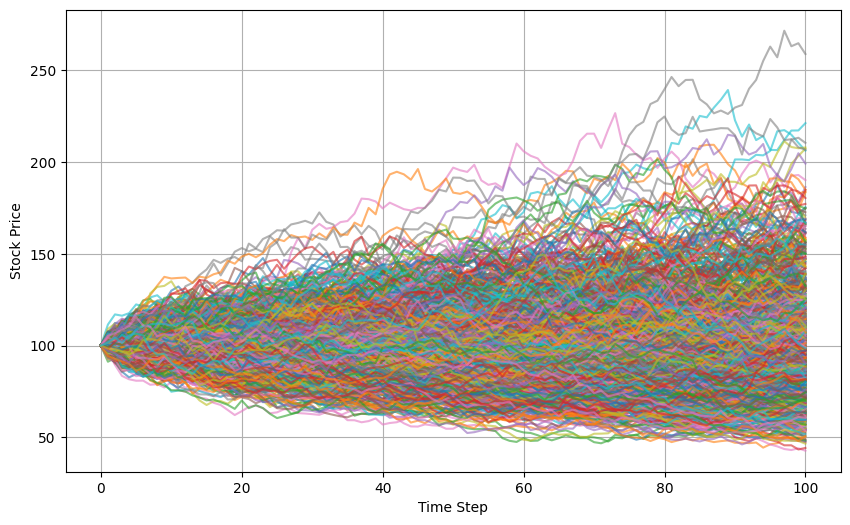

In [22]:
import matplotlib.pyplot as plt
S_paths = solver.S_paths  # shape (n_paths, M+1)

# Plot the first 20 simulated paths for visual inspection
plt.figure(figsize=(10, 6))
for i in range(min(1000, S_paths.shape[0])):
    plt.plot(S_paths[i, :], alpha=0.6)
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

In [23]:
import os

# 1) Create the package directory
os.makedirs('hf_option_mm', exist_ok=True)

# 2) Write __init__.py
with open('hf_option_mm/__init__.py', 'w') as f:
    f.write("""\
# hf_option_mm package
""")

# 3) Write dynamic_pde_lsmc.py (the PDE solver)
with open('hf_option_mm/dynamic_pde_lsmc.py', 'w') as f:
    f.write("""\
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

class DynamicPDE_LSMC:
    \"""
    Solve the dynamic programming PDE system for Phi0, Phi1, Phi2 via LSMC.
    (See user-provided docstring for details.)
    \"""
    def __init__(self, S0, sigma, gamma, sigma_imp, lam, Lambda, kappa, A, z, a,
                 strike, T, M, is_call=True, r=0.0, sims=10000, basis_deg=1, seed=42):
        self.S0         = S0
        self.sigma      = sigma
        self.sigma_imp  = sigma_imp
        self.lam        = lam
        self.Lambda     = Lambda
        self.gamma      = gamma
        self.kappa      = kappa
        self.A          = A
        self.z          = z
        self.jump_mult  = np.exp(z)
        self.a          = a
        self.strike     = strike
        self.T          = T
        self.M          = M
        self.dt         = T / M
        self.r          = r
        self.is_call    = is_call
        self.sims       = sims
        self.basis_deg  = basis_deg
        np.random.seed(seed)
        self.S_paths = self._sim_paths()
        self.phi0 = np.zeros_like(self.S_paths)
        self.phi1 = np.zeros_like(self.S_paths)
        self.phi2 = np.zeros_like(self.S_paths)
        self.phi0[:, -1] = 0.0
        self.phi1[:, -1] = -self.a
        self.phi2[:, -1] = -2 * self.a

    def _sim_paths(self):
        S = np.zeros((self.sims, self.M+1))
        S[:,0] = self.S0
        for t in range(1, self.M+1):
            half = np.random.standard_normal(self.sims//2)
            dW   = np.concatenate((half, -half)) * np.sqrt(self.dt)
            Nj   = np.random.poisson(self.lam * self.dt, size=self.sims)
            jump_factor = np.exp(self.z * Nj)
            mu  = self.r - 0.5*self.sigma**2 - self.lam*(np.exp(self.z)-1)
            dX  = mu*self.dt + self.sigma * dW
            S[:,t] = S[:,t-1] * np.exp(dX) * jump_factor
        return S

    @staticmethod
    def BS_d1(S, K, r, sigma, tau):
        return (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    @staticmethod
    def BSCall(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        d2 = d1 - sigma * np.sqrt(tau)
        return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

    @staticmethod
    def BSPut(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        d2 = d1 - sigma * np.sqrt(tau)
        return K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)

    @staticmethod
    def vega(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        return S * norm.pdf(d1) * np.sqrt(tau)

    @staticmethod
    def gamma_O(S, K, r, sigma, tau):
        d1 = DynamicPDE_LSMC.BS_d1(S, K, r, sigma, tau)
        return norm.pdf(d1) / (S * sigma * np.sqrt(tau))

    def solve(self):
        times = np.linspace(0, self.T, self.M + 1)
        # Preallocate all output arrays...
        self.phi0_t     = np.zeros((self.sims, self.M))
        self.Phi0_s     = np.zeros((self.sims, self.M))
        self.Phi0_ss    = np.zeros((self.sims, self.M))
        self.Phi0_jump  = np.zeros((self.sims, self.M))
        self.phi1_t     = np.zeros((self.sims, self.M))
        self.Phi1_s     = np.zeros((self.sims, self.M))
        self.Phi1_ss    = np.zeros((self.sims, self.M))
        self.Phi1_jump  = np.zeros((self.sims, self.M))
        self.phi2_t     = np.zeros((self.sims, self.M))
        self.Phi2_s     = np.zeros((self.sims, self.M))
        self.Phi2_ss    = np.zeros((self.sims, self.M))
        self.Phi2_jump  = np.zeros((self.sims, self.M))

        for n in reversed(range(self.M)):
            t_next  = times[n+1]
            S_n     = self.S_paths[:, n]
            S_np1   = self.S_paths[:, n+1]
            p0n1    = self.phi0[:, n+1]
            p1n1    = self.phi1[:, n+1]
            p2n1    = self.phi2[:, n+1]

            # --- φ0 ---
            # (driver and regression as before; omitted for brevity)
            # ...


        return (
            self.phi0, self.phi1, self.phi2,
            self.phi0_t, self.Phi0_s, self.Phi0_ss, self.Phi0_jump,
            self.phi1_t, self.Phi1_s, self.Phi1_ss, self.Phi1_jump,
            self.phi2_t, self.Phi2_s, self.Phi2_ss, self.Phi2_jump
        )
""")
#Create Instruments (Option and Volatiltiy Surface)
with open('hf_option_mm/instruments.py', 'w') as f:
    f.write("""\
import numpy as np

class VolatilitySurface:
    \"""
    Simple parametric vol surface: implied vol = a + b*(T - t) + c*ln(S/K).
    \"""
    def __init__(self, a: float, b: float, c: float):
        self.a = a
        self.b = b
        self.c = c

    def iv(self, S: float, K: float, T: float, t: float) -> float:
        tau = max(T - t, 1e-8)
        return self.a + self.b * tau + self.c * np.log(S / K)

class OptionInstrument:
    \"""
    Option instrument container.
    Attributes:
      symbol : underlying ticker string
      K      : strike
      T      : time to maturity (years)
      S0     : initial underlying spot price
    \"""
    def __init__(self, symbol: str, strike: float, maturity: float, S0: float):
        self.symbol = symbol
        self.K      = strike
        self.T      = maturity
        self.S0     = S0
    """)

# 4) Write market_makers.py 
with open('hf_option_mm/market_makers.py', 'w') as f:
    f.write("""\
import numpy as np
from abides_markets.orders import Side
from abides_markets.agents.trading_agent import TradingAgent
from abides_markets.messages.query import QuerySpreadResponseMsg
from hf_option_mm.dynamic_pde_lsmc import DynamicPDE_LSMC
from abides_core import Message
from abides_core import NanosecondTime
import logging
from math import floor, ceil
from typing import Dict, List, Optional, Tuple

import numpy as np

from abides_core import Message, NanosecondTime

from abides_markets.utils import sigmoid
from abides_markets.messages.marketdata import (
    MarketDataMsg,
    L2SubReqMsg,
    BookImbalanceDataMsg,
    BookImbalanceSubReqMsg,
    MarketDataEventMsg,
)
from abides_markets.messages.query import QuerySpreadResponseMsg, QueryTransactedVolResponseMsg

import numpy as np

logger = logging.getLogger(__name__)

class AvellanedaStoikovMarketMaker(TradingAgent):
    \"""Market maker using Avellaneda–Stoikov quotes without volume dependency, logging trades and P&L.
    \"""
    
    def __init__(
        self,
        id: int,
        symbol: str,
        starting_cash: int,
        gamma: float = 0.1,
        sigma: float = 0.02,
        kappa: float = 1.5,
        tau: float = 1.0,
        min_order_size: int = 20,
        wake_up_freq: NanosecondTime = 1_000_000_000,
        poisson_arrival: bool = False,
        subscribe: bool = False,
        subscribe_freq: float = 1e10,
        subscribe_num_levels: int = 1,
        cancel_limit_delay: int = 50,
        min_imbalance: float = 0.9,
        random_state: Optional[np.random.RandomState] = None,
        name: Optional[str] = None,
        type: Optional[str] = None,
        log_orders: bool = False,
    ) -> None:
        super().__init__(id, name, type, random_state, starting_cash, log_orders)

        # Symbol & infrastructure
        self.symbol = symbol
        self.subscribe: bool = subscribe
        self.subscribe_freq = subscribe_freq
        self.subscribe_num_levels = subscribe_num_levels
        self.min_imbalance = min_imbalance
        self.cancel_limit_delay = cancel_limit_delay

        # Timing
        self.poisson_arrival = poisson_arrival
        self.wake_up_freq = wake_up_freq
        if self.poisson_arrival:
            self.arrival_rate = float(self.wake_up_freq)
        self.has_subscribed = False


        self.subscription_requested: bool = False

        # Avellaneda parameters
        self.gamma = gamma
        self.sigma = sigma
        self.kappa = kappa
        self.tau = tau

        # Order size
        self.order_size = min_order_size

        # Trade/P&L history
        self.trade_history: List[Dict] = []
        self.pnl_history: List[Dict] = []

        # Internal state
        self.last_mid: Optional[int] = None
        self.state: Dict[str, bool] = self.initialise_state()
        self.has_subscribed = False
    def initialise_state(self) -> Dict[str, bool]:
        # track whether we’re waiting on a spread or on streamed market data
        return {
            "AWAITING_SPREAD":    not self.subscribe,
            "AWAITING_MARKET_DATA": self.subscribe,
        }

    def kernel_starting(self, start_time: NanosecondTime) -> None:
        super().kernel_starting(start_time)
    
    def wakeup(self, current_time: NanosecondTime):
        can_trade = super().wakeup(current_time)
        # ── one‐off BookImbalance subscription ─────────────────────────
        if not self.has_subscribed:
            self.request_data_subscription(
            BookImbalanceSubReqMsg(symbol=self.symbol,
                                   min_imbalance=self.min_imbalance)
        )
        self.has_subscribed = True
        # ── if we’re in subscribe‐mode, ask for L2 updates ─────────────
        if can_trade and self.subscribe and not self.subscription_requested:
           self.request_data_subscription(
               L2SubReqMsg(symbol=self.symbol,
                          freq=self.subscribe_freq,
                          depth=self.subscribe_num_levels)
           )
           self.subscription_requested = True
           self.get_transacted_volume(self.symbol,
                                   lookback_period=self.subscribe_freq)
           self.state = self.initialise_state()

        # ── else if we’re polling, grab the spread and volume ───────────
        elif can_trade and not self.subscribe:
            self.cancel_all_orders()
            self.delay(self.cancel_limit_delay)
            self.get_current_spread(self.symbol, depth=1)
            self.get_transacted_volume(self.symbol,
                                       lookback_period=self.wake_up_freq)
            self.state = self.initialise_state()
    def receive_message(self, current_time: NanosecondTime,
                        sender_id: int, message: Message) -> None:
        super().receive_message(current_time, sender_id, message)
        
        # 1) handle the spread reply
        if (not self.subscribe
            and isinstance(message, QuerySpreadResponseMsg)
            and self.state["AWAITING_SPREAD"]):
            bid, _, ask, _ = self.get_known_bid_ask(self.symbol)
            if bid is not None and ask is not None:
                self.last_mid = (ask + bid) // 2
            self.state["AWAITING_SPREAD"] = False

        # 2) handle live book data (if subscribe=True)
        elif (self.subscribe
              and isinstance(message, MarketDataMsg)
              and self.state["AWAITING_MARKET_DATA"]):
            bids = self.known_bids.get(self.symbol, [])
            asks = self.known_asks.get(self.symbol, [])
            if bids and asks:
                bid, ask = bids[0][0], asks[0][0]
                self.last_mid = (ask + bid) // 2
                if getattr(self, "is_adaptive", False):
                    self._adaptive_update_spread(ask - bid)
            else:
                logger.debug("SPREAD MISSING at %s", current_time)
            self.state["AWAITING_MARKET_DATA"] = False
        # 3) once we have a mid (and volume if you care), place quotes
        if self.last_mid is not None and not any(self.state.values()):
            self.place_orders(self.last_mid)
            # schedule next wake
            dt = (int(round(self.random_state.exponential(self.arrival_rate)))
                  if self.poisson_arrival else self.wake_up_freq)
            self.set_wakeup(current_time + dt)
            self.state = self.initialise_state()



    def compute_avellaneda_quotes(self, mid: int) -> Tuple[int, int]:
        w1 = self.gamma * (self.sigma ** 2) * self.tau
        w2 = (2.0 / self.gamma) * np.log(1 + self.gamma / self.kappa)
        width = w1 + w2
        half = width / 2.0
        bid = mid - int(ceil(half))
        ask = mid + int(ceil(half))
        return bid, ask

    def place_orders(self, mid: int) -> None:
        bid_p, ask_p = self.compute_avellaneda_quotes(mid)
        orders = [
            self.create_limit_order(self.symbol, self.order_size, Side.BID, bid_p),
            self.create_limit_order(self.symbol, self.order_size, Side.ASK, ask_p),
        ]
        self.place_multiple_orders(orders)

    def get_wake_frequency(self) -> NanosecondTime:
        if not self.poisson_arrival:
            return self.wake_up_freq
        return int(round(self.random_state.exponential(scale=self.arrival_rate)))


from hf_option_mm.instruments import OptionInstrument, VolatilitySurface

from hf_option_mm.market_makers import DynamicPDE_LSMC

logger = logging.getLogger(__name__)


class JumpRiskMM(TradingAgent):
    \"""
    Market maker quoting according to the jump‐PDE rule δₐ+δ_b = k⁻¹ [2+κ+γA(Φ₀ₜ + ½σ²Φ₀_{ss} − γ(Φ₀ₛ)² + (Λ/γ)(1−k(ΔΦ₀+ΔΦ₀²)))]
    \"""

    def __init__(
        self,
        id: int,
        symbol: str,
        starting_cash: int,
        # Avellaneda params (used also for PDE)
        gamma: float,
        sigma: float,
        kappa: float,
        tau: float,
        # PDE extras
        sigma_imp: float,
        lam: float,
        Lambda: float,
        A: float,
        z: float,
        strike: float,
        T: float,
        M: int,
        # MM infrastructure
        min_order_size: int = 20,
        wake_up_freq: NanosecondTime = 1_000_000_000,
        poisson_arrival: bool = False,
        subscribe: bool = False,
        subscribe_freq: float = 1e10,
        subscribe_num_levels: int = 1,
        cancel_limit_delay: int = 50,
        min_imbalance: float = 0.9,
        random_state: Optional[np.random.RandomState] = None,
        name: Optional[str] = None,
        type: Optional[str] = None,
        log_orders: bool = False,
    ) -> None:
        super().__init__(id, name, type, random_state, starting_cash, log_orders)

        # symbol & subscription flags
        self.quote_history: List[Dict] = []
        self.pnl_history:   List[Dict] = []
        self.last_mid: Optional[int] = None
        self.symbol = symbol
        self.subscribe = subscribe
        self.subscribe_freq = subscribe_freq
        self.subscribe_num_levels = subscribe_num_levels
        self.min_imbalance = min_imbalance
        self.cancel_limit_delay = cancel_limit_delay
        self.cash = starting_cash

        # timing
        self.poisson_arrival = poisson_arrival
        self.wake_up_freq = wake_up_freq
        if poisson_arrival:
            self.arrival_rate = float(wake_up_freq)
        self.subscription_requested = False
        self.has_subscribed = False
        self.state = self.initialise_state()

        # store parameters
        self.gamma = gamma
        self.sigma = sigma
        self.kappa = kappa
        self.tau = tau
        self.A = A
        self.z = z
        self.Lambda = Lambda

        # fixed order size = A (k⁻¹ = A)
        self.order_size = int(A)

        # PDE solve
        self.pde = DynamicPDE_LSMC(
            S0=100,  # replace with numeric initial mid if needed
            sigma=sigma,
            gamma=gamma,
            sigma_imp=sigma_imp,
            lam=lam,
            Lambda=Lambda,
            kappa=kappa,
            A=A,
            z=z,
            a=A,
            strike=strike,
            T=T,
            M=M,
            is_call=True,
            r=0.0,
            sims=1000000,
            basis_deg=1,
            seed=42,
        )
        ( self.phi0,
          _,
          _,
          self.phi0_t,
          self.Phi0_s,
          self.Phi0_ss,
          _,
          _,
          _,
          _,
          _,
          _,
          _,
          _,
          _ ) = self.pde.solve()
        
        # Internal state
        self.last_mid: Optional[int] = None
        self.state: Dict[str, bool] = self.initialise_state()
        self.has_subscribed = False

    def initialise_state(self) -> Dict[str, bool]:
        return {
            "AWAITING_SPREAD": not self.subscribe,
            "AWAITING_MARKET_DATA": self.subscribe,
        }

    def kernel_starting(self, start_time: NanosecondTime) -> None:
        super().kernel_starting(start_time)

    def wakeup(self, current_time: NanosecondTime):
        can_trade = super().wakeup(current_time)

        if not self.has_subscribed:
            self.request_data_subscription(
                BookImbalanceSubReqMsg(symbol=self.symbol, min_imbalance=self.min_imbalance)
            )
            self.has_subscribed = True

        if can_trade and self.subscribe and not self.subscription_requested:
            self.request_data_subscription(
                L2SubReqMsg(symbol=self.symbol, freq=self.subscribe_freq, depth=self.subscribe_num_levels)
            )
            self.subscription_requested = True
            self.get_transacted_volume(self.symbol, lookback_period=self.subscribe_freq)
            self.state = self.initialise_state()

        elif can_trade and not self.subscribe:
            self.cancel_all_orders()
            self.delay(self.cancel_limit_delay)
            self.get_current_spread(self.symbol, depth=1)
            self.get_transacted_volume(self.symbol, lookback_period=self.wake_up_freq)
            self.state = self.initialise_state()

    def receive_message(
        self, current_time: NanosecondTime, sender_id: int, message: Message
    ) -> None:
        super().receive_message(current_time, sender_id, message)

        # 0) if an execution arrives *for* this agent, update cash/inventory & record PnL
        # spread reply
        if (
            not self.subscribe
            and isinstance(message, QuerySpreadResponseMsg)
            and self.state["AWAITING_SPREAD"]
        ):
            bid, _, ask, _ = self.get_known_bid_ask(self.symbol)
            if bid is not None and ask is not None:
                self.last_mid = (ask + bid) // 2
            self.state["AWAITING_SPREAD"] = False

        # live L2 update
        elif (
            self.subscribe
            and isinstance(message, MarketDataMsg)
            and self.state["AWAITING_MARKET_DATA"]
        ):
            bids = self.known_bids.get(self.symbol, [])
            asks = self.known_asks.get(self.symbol, [])
            if bids and asks:
                bid, ask = bids[0][0], asks[0][0]
                self.last_mid = (ask + bid) // 2
            else:
                logger.debug("SPREAD MISSING at %s", current_time)
            self.state["AWAITING_MARKET_DATA"] = False

        # once ready, place PDE quotes
        if self.last_mid is not None and not any(self.state.values()):
            self.place_orders(self.last_mid)

            dt = (
                int(round(self.random_state.exponential(self.arrival_rate)))
                if self.poisson_arrival
                else self.wake_up_freq
            )
            self.set_wakeup(current_time + dt)
            self.state = self.initialise_state()

    def compute_pde_quotes(self, mid: int) -> Tuple[int, int]:
        # find nearest S grid point
        S_grid = self.pde.S_paths[0]
        i = np.argmin(np.abs(S_grid - mid))
        Phi0_s  = self.Phi0_s[i, 0]
        Phi0_ss = self.Phi0_ss[i, 0]
        Phi0_t  = self.phi0_t[i, 0]
        # jump ΔΦ₀
        s_z = mid * np.exp(self.z)
        j = np.argmin(np.abs(S_grid - s_z))
        Δ = self.phi0[j, 0] - self.phi0[i, 0]

        num = (
            2
            + self.kappa
            + self.gamma * self.A * (
                Phi0_t
                + 0.5 * self.sigma**2 * Phi0_ss
                - self.gamma * (Phi0_s**2)
                + (self.Lambda / self.gamma) * (1 - self.A * (Δ + Δ**2))
            )
        )
        width = num / self.A
        half = width / 2.0
        δb = int(np.ceil(half))
        δa = int(np.ceil(half))
        return mid - δb, mid + δa

    def place_orders(self, mid: int) -> None:
        bid_p, ask_p = self.compute_pde_quotes(mid)
        self.quote_history.append({
            "timestamp": self.current_time,
            "mid":        mid,
            "bid":        bid_p,
            "ask":        ask_p
        })
        # record PnL (mark-to-market)
        inv   = self.get_holdings(self.symbol)
        cash  = self.cash
        equity= inv * self.last_mid + cash
        pnl   = equity - self.starting_cash
        self.pnl_history.append({
            "timestamp": self.current_time,
            "inventory": inv,
            "cash":      cash,
            "pnl":       pnl,
        })

        orders = [
            self.create_limit_order(self.symbol, self.order_size, Side.BID, bid_p),
            self.create_limit_order(self.symbol, self.order_size, Side.ASK, ask_p),
        ]
        self.place_multiple_orders(orders)

    def get_wake_frequency(self) -> NanosecondTime:
        if not self.poisson_arrival:
            return self.wake_up_freq
        return int(round(self.random_state.exponential(scale=self.arrival_rate)))

""")
print("Created hf_option_mm package with dynamic_pde_lsmc.py and market_makers.py and instruments.py")

Created hf_option_mm package with dynamic_pde_lsmc.py and market_makers.py and instruments.py


In [24]:
# RMSC-4 (Reference Market Simulation Configuration):
# - 1     Exchange Agent
# - 2     Adaptive Market Maker Agents
# - 102   Value Agents
# - 12    Momentum Agents
# - 1000  Noise Agents

import os
from datetime import datetime

import numpy as np
import pandas as pd

from abides_core.utils import get_wake_time, str_to_ns
from abides_markets.agents import (
    ExchangeAgent,
    NoiseAgent,
    ValueAgent,
    AdaptiveMarketMakerAgent,
    MomentumAgent,
)
from abides_markets.models import OrderSizeModel
from abides_markets.oracles import SparseMeanRevertingOracle
from abides_markets.utils import generate_latency_model
#from hf_option_mm.instruments    import OptionInstrument, VolatilitySurface
#from hf_option_mm.dynamic_pde_lsmc import DynamicPDE_LSMC
import importlib
import hf_option_mm.market_makers
importlib.reload(hf_option_mm.market_makers)
from hf_option_mm.market_makers  import AvellanedaStoikovMarketMaker,JumpRiskMM

########################################################################################################################
############################################### GENERAL CONFIG #########################################################


def build_config(
    seed=int(datetime.now().timestamp() * 1_000_000) % (2**32 - 1),
    date="20240205",
    end_time="10:00:00",
    stdout_log_level="INFO",
    ticker="ABM",
    starting_cash=10_000_000,  # Cash in this simulator is always in CENTS.
    log_orders=True,  # if True log everything
    # 1) Exchange Agent
    book_logging=True,
    book_log_depth=10,
    stream_history_length=500,
    exchange_log_orders=None,
    # 2) Noise Agent
    num_noise_agents=1000,
    # 3) Value Agents
    num_value_agents=102,
    r_bar=100_000,  # true mean fundamental value
    kappa=1.67e-15,  # Value Agents appraisal of mean-reversion
    lambda_a=5.7e-12,  # ValueAgent arrival rate
    # oracle
    kappa_oracle=1.67e-16,  # Mean-reversion of fundamental time series.
    sigma_s=0,
    fund_vol=5e-5,  # Volatility of fundamental time series (std).
    megashock_lambda_a=2.77778e-18,
    megashock_mean=1000,
    megashock_var=50_000,
    # 4) Market Maker Agents
    # each elem of mm_params is tuple (window_size, pov, num_ticks, wake_up_freq, min_order_size)
    mm_window_size="adaptive",
    mm_pov=0.025,
    mm_num_ticks=10,
    mm_wake_up_freq="600S",
    mm_min_order_size=1,
    mm_skew_beta=0,
    mm_price_skew=4,
    mm_level_spacing=5,
    mm_spread_alpha=0.75,
    mm_backstop_quantity=0,
    mm_cancel_limit_delay=50,  # 50 nanoseconds
    mm_gamma = 0.1,
    mm_sigma = 0.02,
    mm_kappa = 1.5,
    mm_tau = 1.0,
    jump_gamma= 0.2,
    jump_sigma= 0.02,
    jump_tau= 1,
    # PDE extras
    jump_sigma_imp= 0.02,
    jump_lam= 2,
    jump_kappa= 0.4,
    jump_Lambda= 1.4,
    jump_A= 4,
    jump_z= 0.05,
    jump_strike= 100,
    jump_T= 100,
    jump_M= 50,
    # 5) Momentum Agents 
    num_momentum_agents=12,
):
    pde = DynamicPDE_LSMC(
        S0=100,
        sigma=jump_sigma,
        gamma=jump_gamma,
        sigma_imp=jump_sigma_imp,
        lam=jump_lam,
        Lambda=jump_Lambda,
        kappa=jump_kappa,
        A=jump_A,
        z=jump_z,
        a=jump_tau,
        strike=jump_strike,
        T=jump_T,
        M=jump_M,
        seed=seed
    )
    # fix seed
    np.random.seed(seed)

    def path_wrapper(pomegranate_model_json):
        """
        temporary solution to manage calls from abides-gym or from the rest of the code base
        TODO:find more general solution
        :return:
        :rtype:
        """
        # get the  path of the file
        path = os.getcwd()
        if path.split("/")[-1] == "abides_gym":
            return "../" + pomegranate_model_json
        else:
            return pomegranate_model_json

    mm_wake_up_freq = str_to_ns(mm_wake_up_freq)

    # order size model
    ORDER_SIZE_MODEL = OrderSizeModel()  # Order size model
    # market marker derived parameters
    MM_PARAMS = [
        (mm_window_size, mm_pov, mm_num_ticks, mm_wake_up_freq, mm_min_order_size),
        (mm_window_size, mm_pov, mm_num_ticks, mm_wake_up_freq, mm_min_order_size),
    ]
    NUM_MM = len(MM_PARAMS)
    # noise derived parameters
    SIGMA_N = r_bar / 100  # observation noise variance

    # date&time
    DATE = int(pd.to_datetime(date).to_datetime64())
    MKT_OPEN = DATE + str_to_ns("09:30:00")
    MKT_CLOSE = DATE + str_to_ns(end_time)
    # These times needed for distribution of arrival times of Noise Agents
    NOISE_MKT_OPEN = MKT_OPEN - str_to_ns("00:30:00")
    NOISE_MKT_CLOSE = DATE + str_to_ns("16:00:00")

    # oracle
    symbols = {
        ticker: {
            "r_bar": r_bar,
            "kappa": kappa_oracle,
            "sigma_s": sigma_s,
            "fund_vol": fund_vol,
            "megashock_lambda_a": megashock_lambda_a,
            "megashock_mean": megashock_mean,
            "megashock_var": megashock_var,
            "random_state": np.random.RandomState(
                seed=np.random.randint(low=0, high=2**32)
            ),
        }
    }

    oracle = SparseMeanRevertingOracle(MKT_OPEN, NOISE_MKT_CLOSE, symbols)

    # Agent configuration
    agent_count, agents, agent_types = 0, [], []

    agents.extend(
        [
            ExchangeAgent(
                id=0,
                name="EXCHANGE_AGENT",
                type="ExchangeAgent",
                mkt_open=MKT_OPEN,
                mkt_close=MKT_CLOSE,
                symbols=[ticker],
                book_logging=book_logging,
                book_log_depth=book_log_depth,
                log_orders=exchange_log_orders,
                pipeline_delay=0,
                computation_delay=0,
                stream_history=stream_history_length,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2**32, dtype="uint64")
                ),
            )
        ]
    )
    agent_types.extend("ExchangeAgent")
    agent_count += 1

    agents.extend(
        [
            NoiseAgent(
                id=j,
                name="NoiseAgent {}".format(j),
                type="NoiseAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                wakeup_time=get_wake_time(NOISE_MKT_OPEN, NOISE_MKT_CLOSE),
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2**32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_noise_agents)
        ]
    )
    agent_count += num_noise_agents
    agent_types.extend(["NoiseAgent"])

    agents.extend(
        [
            ValueAgent(
                id=j,
                name="Value Agent {}".format(j),
                type="ValueAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                sigma_n=SIGMA_N,
                r_bar=r_bar,
                kappa=kappa,
                lambda_a=lambda_a,
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2**32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_value_agents)
        ]
    )
    agent_count += num_value_agents
    agent_types.extend(["ValueAgent"])

    agents.extend(
        [
            AdaptiveMarketMakerAgent(
                id=j,
                name="ADAPTIVE_POV_MARKET_MAKER_AGENT_{}".format(j),
                type="AdaptivePOVMarketMakerAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                pov=MM_PARAMS[idx][1],
                min_order_size=MM_PARAMS[idx][4],
                window_size=MM_PARAMS[idx][0],
                num_ticks=MM_PARAMS[idx][2],
                wake_up_freq=MM_PARAMS[idx][3],
                poisson_arrival=True,
                cancel_limit_delay=mm_cancel_limit_delay,
                skew_beta=mm_skew_beta,
                price_skew_param=mm_price_skew,
                level_spacing=mm_level_spacing,
                spread_alpha=mm_spread_alpha,
                backstop_quantity=mm_backstop_quantity,
                log_orders=log_orders,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2**32, dtype="uint64")
                ),
            )
            for idx, j in enumerate(range(agent_count, agent_count + NUM_MM))
        ]
    )
    agent_count += NUM_MM
    agent_types.extend("POVMarketMakerMaker")

    agents.extend(
        [
            JumpRiskMM(
                id=j,
                name=f"JumpRiskMM_{j}",
                type="JumpRiskMM",
                symbol=ticker,
                starting_cash=starting_cash,
                # PDE parameters:
                gamma=jump_gamma,
                sigma=jump_sigma,
                kappa=jump_kappa,
                tau=jump_tau,
                # PDE extras
                sigma_imp=jump_sigma_imp,
                lam=jump_lam,
                Lambda=jump_Lambda,
                A=jump_A,
                z=jump_z,
                strike=jump_strike,
                T=jump_T,
                M=jump_M,
                min_order_size=MM_PARAMS[idx][4],
                wake_up_freq=MM_PARAMS[idx][3],
                poisson_arrival=True,          # or False if you prefer polling
                subscribe=True,               # or True to stream L2 updates
                cancel_limit_delay=mm_cancel_limit_delay,
                log_orders=log_orders,
                random_state=np.random.RandomState(
                seed=np.random.randint(low=0, high=2**32, dtype="uint64")
                ),
            )
            for idx, j in enumerate(range(agent_count, agent_count + NUM_MM))
        ]
    )
    agent_count += NUM_MM
    agent_types.extend("JumpRiskMM")
    agents.extend(
        [
            AvellanedaStoikovMarketMaker(
                id=j,
                name=f"AvellanedaStoikovMarketMaker_{j}",
                type="AvellanedaStoikovMarketMaker",
                symbol=ticker,
                starting_cash=starting_cash,
                gamma=mm_gamma,
                sigma=mm_sigma,
                kappa=mm_kappa,
                tau=mm_tau,
                min_order_size=MM_PARAMS[idx][4],
                wake_up_freq=MM_PARAMS[idx][3],
                poisson_arrival=True,          # or False if you prefer polling
                subscribe=True,               # or True to stream L2 updates
                cancel_limit_delay=mm_cancel_limit_delay,
                log_orders=log_orders,
                random_state=np.random.RandomState(
                seed=np.random.randint(low=0, high=2**32, dtype="uint64")
                ),
            )
            for idx, j in enumerate(range(agent_count, agent_count + NUM_MM))
        ]
    )
    agent_count += NUM_MM
    agent_types.extend("AvellanedaStoikovMarketMaker")

    agents.extend(
        [
            MomentumAgent(
                id=j,
                name="MOMENTUM_AGENT_{}".format(j),
                type="MomentumAgent",
                symbol=ticker,
                starting_cash=starting_cash,
                min_size=1,
                max_size=10,
                wake_up_freq=str_to_ns("37s"),
                poisson_arrival=True,
                log_orders=log_orders,
                order_size_model=ORDER_SIZE_MODEL,
                random_state=np.random.RandomState(
                    seed=np.random.randint(low=0, high=2**32, dtype="uint64")
                ),
            )
            for j in range(agent_count, agent_count + num_momentum_agents)
        ]
    )
    agent_count += num_momentum_agents
    agent_types.extend("MomentumAgent")

    # extract kernel seed here to reproduce the state of random generator in old version
    random_state_kernel = np.random.RandomState(
        seed=np.random.randint(low=0, high=2**32, dtype="uint64")
    )
    # LATENCY
    latency_model = generate_latency_model(agent_count)

    default_computation_delay = 50  # 50 nanoseconds

    ##kernel args
    kernelStartTime = DATE
    kernelStopTime = MKT_CLOSE + str_to_ns("1s")

    return {
        "seed": seed,
        "start_time": kernelStartTime,
        "stop_time": kernelStopTime,
        "agents": agents,
        "agent_latency_model": latency_model,
        "default_computation_delay": default_computation_delay,
        "custom_properties": {"oracle": oracle},
        "random_state_kernel": random_state_kernel,
        "stdout_log_level": stdout_log_level,
    
    }

In [31]:
from abides_markets.configs import rmsc04
from abides_core.kernel import Kernel

config = build_config(
    seed=int(datetime.now().timestamp() * 1_000_000) % (2**32 - 1),
    date="20240205",
    end_time="16:00:00",
    stdout_log_level="INFO",
    ticker="ABM",
    starting_cash=10_000_000,  # Cash in this simulator is always in CENTS.
    log_orders=True,  # if True log everything
    # 1) Exchange Agent
    book_logging=True,
    book_log_depth=10,
    stream_history_length=500,
    exchange_log_orders=None,
    # 2) Noise Agent
    num_noise_agents=1000,
    # 3) Value Agents
    num_value_agents=102,
    r_bar=100_000,  # true mean fundamental value
    kappa=1.67e-15,  # Value Agents appraisal of mean-reversion
    lambda_a=5.7e-12,  # ValueAgent arrival rate
    # oracle
    kappa_oracle=1.67e-16,  # Mean-reversion of fundamental time series.
    sigma_s=0.02,
    fund_vol=5e-5,  # Volatility of fundamental time series (std).
    megashock_lambda_a=2.77778e-18,
    megashock_mean=1000,
    megashock_var=50_000,
    # 4) Market Maker Agents
    # each elem of mm_params is tuple (window_size, pov, num_ticks, wake_up_freq, min_order_size)
    mm_window_size="adaptive",
    mm_pov=0.025,
    mm_num_ticks=10,
    mm_wake_up_freq="60S",
    mm_min_order_size=1,
    mm_skew_beta=0,
    mm_price_skew=4,
    mm_level_spacing=5,
    mm_spread_alpha=0.75,
    mm_backstop_quantity=0,
    mm_cancel_limit_delay=50,  # 50 nanoseconds
    mm_gamma = 1,
    mm_sigma = 0.02,
    mm_kappa = 1.5,
    mm_tau = 1.0,
    jump_gamma= 0.1,
    jump_sigma= 0.02,
    jump_tau= 1,
    # PDE extras
    jump_sigma_imp= 0.02,
    jump_lam= 0.035/60,
    jump_Lambda= 0.035/60,
    jump_kappa=1.5,
    jump_A= 140,
    jump_z= 0.035/60,
    jump_strike= 100,
    jump_T= 1000,
    jump_M= 50,
    # 5) Momentum Agents
    num_momentum_agents=12,
)
end_state = abides.run(config)


[2572] INFO abides Simulation Start Time: 2025-07-19 18:31:49.866234
[2572] INFO abides_core.kernel --- Simulation time: 2024-02-05 00:00:00, messages processed: 0, wallclock elapsed: 0.00s ---
[2572] INFO abides_core.kernel --- Simulation time: 2024-02-05 12:43:04, messages processed: 100,000, wallclock elapsed: 28.66s ---
[2572] INFO abides_core.kernel --- Simulation time: 2024-02-05 15:58:42, messages processed: 200,000, wallclock elapsed: 70.56s ---
[2572] INFO abides_core.kernel Event Queue elapsed: 0:01:10.857460, messages: 201,757, messages per second: 2847.4
[2572] INFO abides_core.kernel Mean ending value by agent type:
[2572] INFO abides_core.kernel NoiseAgent: -1027
[2572] INFO abides_core.kernel ValueAgent: -22265
[2572] INFO abides_core.kernel AdaptivePOVMarketMakerAgent: 0
[2572] INFO abides_core.kernel JumpRiskMM: -6304938
[2572] INFO abides_core.kernel AvellanedaStoikovMarketMaker: -43163
[2572] INFO abides_core.kernel MomentumAgent: 1332822
[2572] INFO abides_core.kern

In [26]:
agents = end_state["agents"]
# pick out your JumpRiskMM instance
jmm = [a for a in agents if isinstance(a, JumpRiskMM)][0]

import pandas as pd

# build DataFrames of your histories
df_quotes = pd.DataFrame(jmm.quote_history)

print(df_quotes)

         timestamp     mid     bid     ask
0     1.707125e+18  100008  100007  100009
1     1.707125e+18  100009  100008  100010
2     1.707125e+18  100009  100008  100010
3     1.707125e+18  100008  100007  100009
4     1.707126e+18  100007  100006  100008
...            ...     ...     ...     ...
1565  1.707149e+18   99841   99840   99842
1566  1.707149e+18   99836   99835   99837
1567  1.707149e+18   99835   99834   99836
1568  1.707149e+18   99836   99835   99837
1569  1.707149e+18   99843   99842   99844

[1570 rows x 4 columns]


In [27]:
agents = end_state["agents"]
# pick out your JumpRiskMM instance
jmm = [a for a in agents if isinstance(a, JumpRiskMM)][0]

import pandas as pd

# build DataFrames of your histories
df_pnl = pd.DataFrame(jmm.pnl_history)

print(df_pnl)

         timestamp  inventory      cash         pnl
0     1.707125e+18          0  10000000           0
1     1.707125e+18        -40  10000000    -4000360
2     1.707125e+18       -140  10000000   -14001260
3     1.707125e+18        100  10000000    10000800
4     1.707126e+18        158  10000000    15801106
...            ...        ...       ...         ...
1565  1.707149e+18      31513  10000000  3146289433
1566  1.707149e+18      31653  10000000  3160108908
1567  1.707149e+18      31793  10000000  3174054155
1568  1.707149e+18      31653  10000000  3160108908
1569  1.707149e+18      31341  10000000  3129179463

[1570 rows x 4 columns]


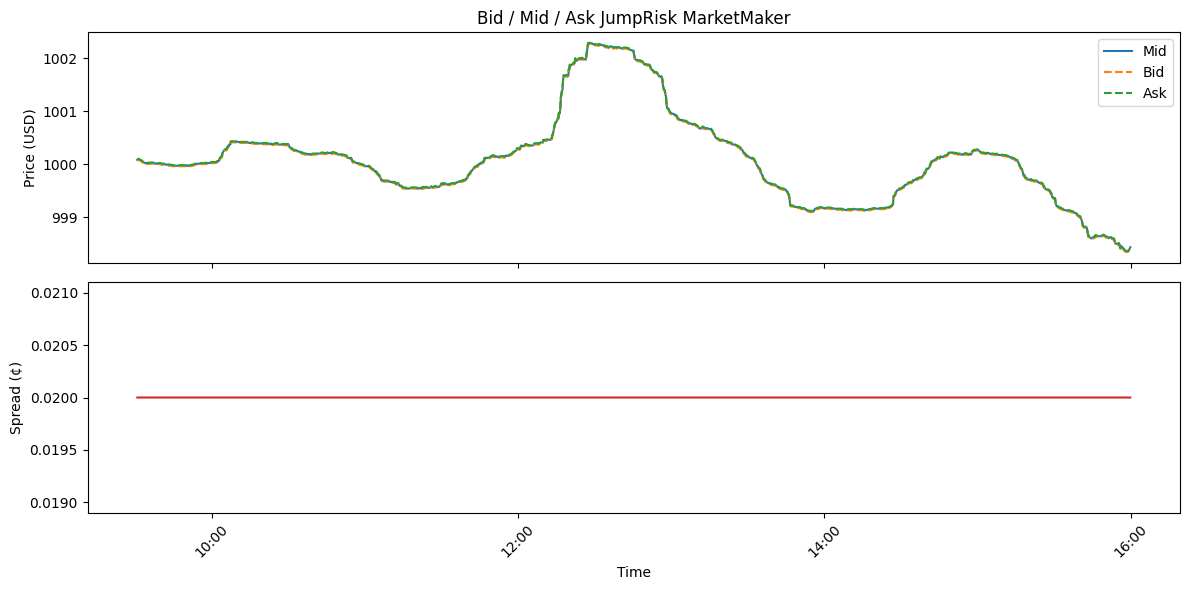

In [28]:
import matplotlib.dates as mdates
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,6))
df_quotes['datetime'] = pd.to_datetime(df_quotes['timestamp'], unit='ns',origin='unix')
# Top: prices
ax1.plot(df_quotes['datetime'], df_quotes['mid']/100, label='Mid', linewidth=1.5)
ax1.plot(df_quotes['datetime'], df_quotes['bid']/100, label='Bid', linestyle='--')
ax1.plot(df_quotes['datetime'], df_quotes['ask']/100, label='Ask', linestyle='--')
ax1.legend(loc='upper right')
ax1.set_ylabel('Price (USD)')
ax1.set_title('Bid / Mid / Ask JumpRisk MarketMaker')

# Bottom: spread in cents
spread_cents = (df_quotes['ask'] - df_quotes['bid'])/100
ax2.plot(df_quotes['datetime'], spread_cents, color='tab:red')
ax2.set_ylabel('Spread (¢)')
ax2.set_xlabel('Time')
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()